<a href="https://colab.research.google.com/github/mAbbaspour/Hyperparameter-Optimization/blob/main/Bace(10nd_version)(Final_version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
try:
    import ray
except:
    !pip install -U ray
    import ray
try:
    import optuna
except:
    %pip install optuna
    import optuna
    %%capture
try:
    from featurewiz import featurewiz
except:
    !pip install featurewiz==0.1.70


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from pandas import read_csv
from sklearn.impute import SimpleImputer
import io
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from functools import partial
import os
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torchsummary import summary
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler


In [ ]:
from google.colab import files
uploaded1 = files.upload()

Saving bace(lables).csv to bace(lables) (3).csv


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving bace_global_cdf_rdkit.csv to bace_global_cdf_rdkit (3).csv


In [ ]:
dataX = pd.read_csv(io.BytesIO(uploaded['bace_global_cdf_rdkit.csv']))
dataX.head()

,"('RDKit2DNormalized_calculated', <class 'bool'>)","('BalabanJ', <class 'numpy.float64'>)","('BertzCT', <class 'numpy.float64'>)","('Chi0', <class 'numpy.float64'>)","('Chi0n', <class 'numpy.float64'>)","('Chi0v', <class 'numpy.float64'>)","('Chi1', <class 'numpy.float64'>)","('Chi1n', <class 'numpy.float64'>)","('Chi1v', <class 'numpy.float64'>)","('Chi2n', <class 'numpy.float64'>)",...,"('fr_sulfonamd', <class 'numpy.float64'>)","('fr_sulfone', <class 'numpy.float64'>)","('fr_term_acetylene', <class 'numpy.float64'>)","('fr_tetrazole', <class 'numpy.float64'>)","('fr_thiazole', <class 'numpy.float64'>)","('fr_thiocyan', <class 'numpy.float64'>)","('fr_thiophene', <class 'numpy.float64'>)","('fr_unbrch_alkane', <class 'numpy.float64'>)","('fr_urea', <class 'numpy.float64'>)","('qed', <class 'numpy.float64'>)"
0,True,0.271693,0.685231,0.715429,0.780380,0.750726,0.689887,0.776209,0.716683,0.850783,...,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.494794
1,True,0.392419,0.830920,0.964192,0.966658,0.963590,0.957524,0.968433,0.959626,0.970019,...,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.072174
2,True,0.149225,0.951733,0.924019,0.927351,0.932271,0.923493,0.923177,0.942919,0.908699,...,9.999565e-01,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.090157
3,True,0.577532,0.782187,0.924370,0.906913,0.913072,0.876879,0.885455,0.922284,0.928759,...,1.593061e-17,1.000000e+00,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.121917
4,True,0.138106,0.967050,0.945002,0.930853,0.935559,0.936328,0.928579,0.946799,0.921161,...,9.999565e-01,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.091591


In [ ]:
dataY = pd.read_csv(io.BytesIO(uploaded1['bace(lables).csv']))
dataY.head()


,mol,Class
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,1
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,1
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,1
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,1
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,1


In [ ]:
#del dataX["('RDKit2DNormalized_calculated', <class 'bool'>)"]

dataX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Columns: 201 entries, ('RDKit2DNormalized_calculated', <class 'bool'>) to ('qed', <class 'numpy.float64'>)
dtypes: bool(1), float64(200)
memory usage: 2.3 MB


In [ ]:
Y = dataY.iloc[:, 1]


In [ ]:
Y.value_counts()

0    822
1    691
Name: Class, dtype: int64

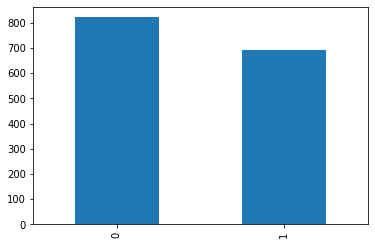

In [ ]:
Y.value_counts().plot(kind='bar')


In [ ]:
dataX.isnull().sum().sum()

0

**Corrolation** **matrix**



In [ ]:
# corr_matrix = dataX.corr()
#  #This approach is fatsitc it looks at the previous column if the correlation is high it removes it

# # Create correlation matrix
# corr_matrix = dataX.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(
#     np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# # Find features with correlation greater than 0.90
# to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# # Drop features
# data = dataX.drop(to_drop, axis=1)
# data

**Split** **Data**



In [ ]:
random.seed(1234)

In [ ]:
from sklearn.model_selection import train_test_split
X=dataX.iloc[:,1:201]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15,random_state=1234)

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
**INFO: featurewiz can now read feather formatted files. Loading train data...
    Shape of your Data Set loaded: (1286, 201)
    Loaded train data. Shape = (1286, 201)
    Some column names had special characters which were removed...
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#################################################

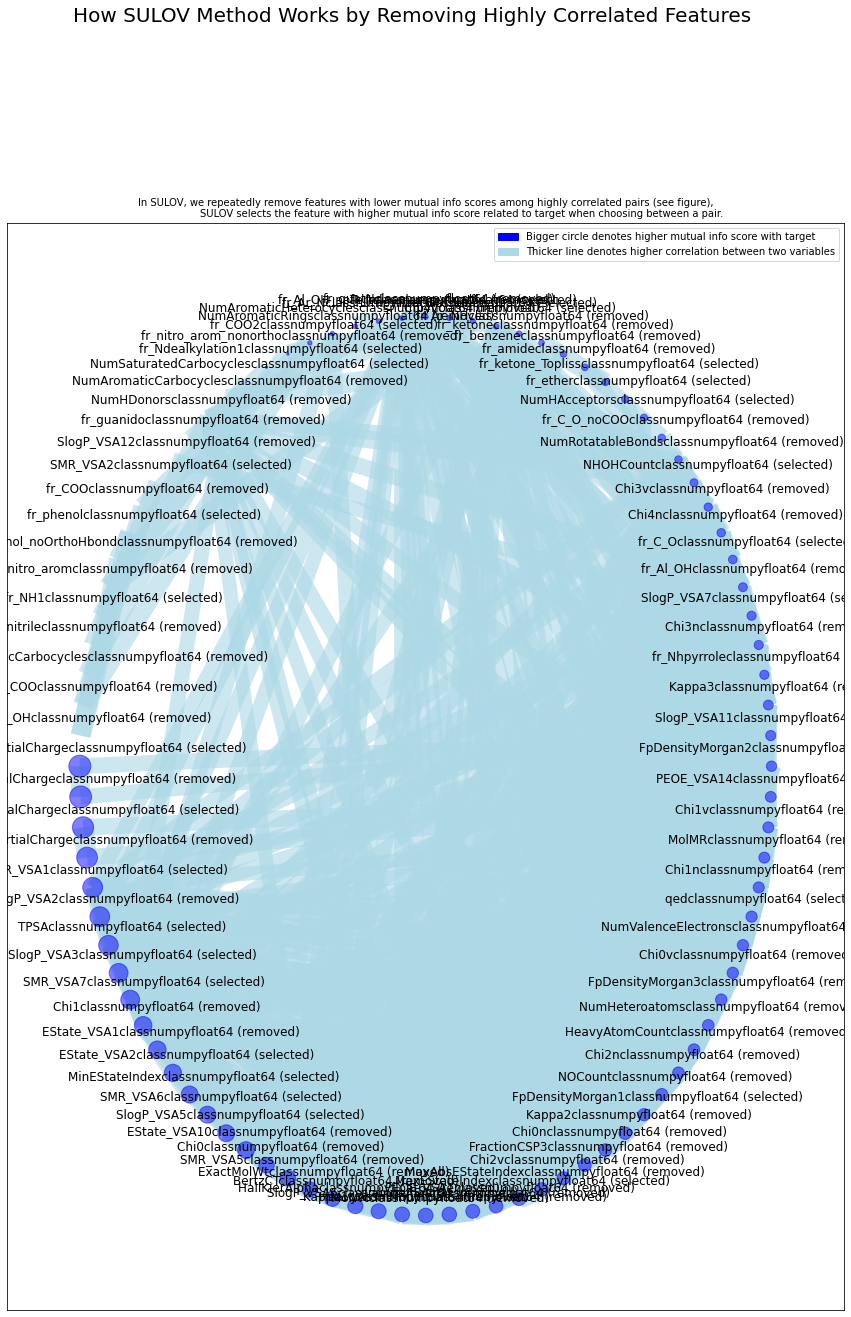

Time taken for SULOV method = 4 seconds
    Adding 0 categorical variables to reduced numeric variables  of 105
Final list of selected vars after SULOV = 105
Readying dataset for Recursive XGBoost by converting all features to numeric...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Train and Test loaded into Dask dataframes successfully after feature_engg completed
Current number of predictors = 105 
    XGBoost version: 1.6.1
Number of booster rounds = 100
        using 105 variables...
            Time taken for regular XGBoost feature selection = 2 seconds
        using 84 variables...
            Time taken for regular XGBoost feature selection = 5 seconds
        using 63 variables...
            Time taken for regular XGBoost feature selec

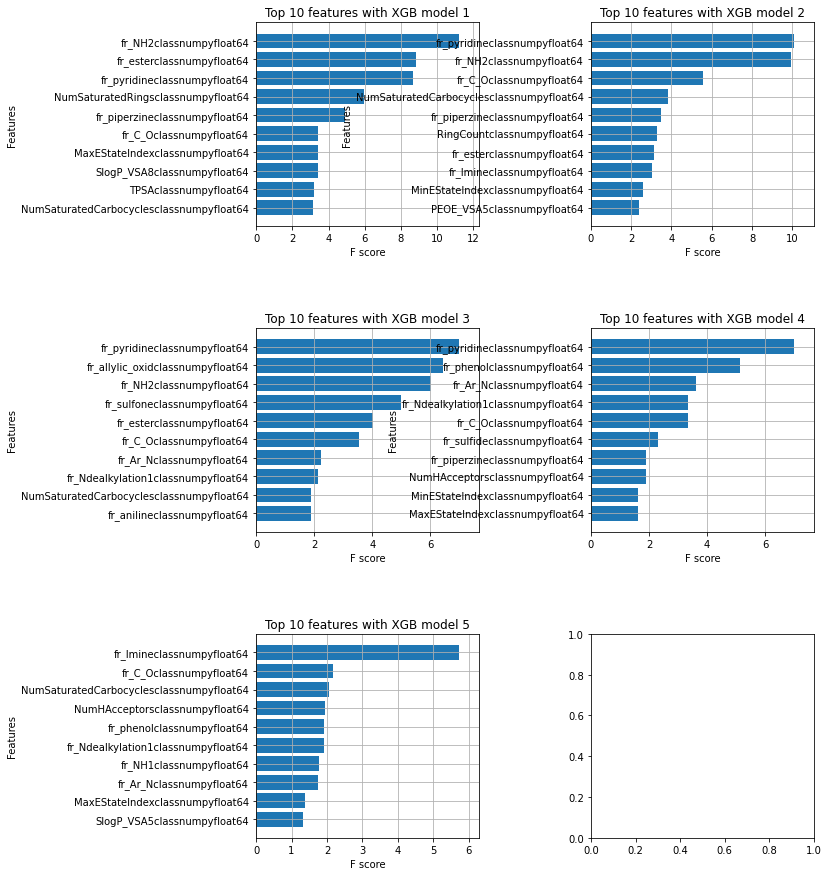

            Total time taken for XGBoost feature selection = 12 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 56 important features. Too many to print...

    Time taken for feature selection = 15 seconds
Returning 2 dataframes: dataname and test_data with 56 important features.
    Time taken to create entire pipeline = 17 second(s)


["('fr_NH2', <class 'numpy.float64'>)",
 "('fr_ester', <class 'numpy.float64'>)",
 "('fr_pyridine', <class 'numpy.float64'>)",
 "('NumSaturatedRings', <class 'numpy.float64'>)",
 "('fr_piperzine', <class 'numpy.float64'>)",
 "('fr_C_O', <class 'numpy.float64'>)",
 "('MaxEStateIndex', <class 'numpy.float64'>)",
 "('SlogP_VSA8', <class 'numpy.float64'>)",
 "('TPSA', <class 'numpy.float64'>)",
 "('NumSaturatedCarbocycles', <class 'numpy.float64'>)",
 "('PEOE_VSA4', <class 'numpy.float64'>)",
 "('SMR_VSA10', <class 'numpy.float64'>)",
 "('fr_aryl_methyl', <class 'numpy.float64'>)",
 "('NumHAcceptors', <class 'numpy.float64'>)",
 "('MinEStateIndex', <class 'numpy.float64'>)",
 "('SlogP_VSA5', <class 'numpy.float64'>)",
 "('MaxPartialCharge', <class 'numpy.float64'>)",
 "('SlogP_VSA4', <class 'numpy.float64'>)",
 "('VSA_EState10', <class 'numpy.float64'>)",
 "('PEOE_VSA12', <class 'numpy.float64'>)",
 "('SlogP_VSA1', <class 'numpy.float64'>)",
 "('PEOE_VSA11', <class 'numpy.float64'>)",
 "('

In [ ]:

from featurewiz import FeatureWiz
features = FeatureWiz(corr_limit=0.70, feature_engg='', category_encoders='', dask_xgboost_flag=False, nrows=None, verbose=2)
X_train = features.fit_transform(X_train, Y_train)
X_test = features.transform(X_test)
features.features  ### provides the list of selected features ###

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

**Scaling** **data**


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import random
np.random.seed(1234)

from sklearn import preprocessing
scaler_data = preprocessing.MinMaxScaler()
X_train = scaler_data.fit_transform(X_train)
X_test = scaler_data.transform(X_test)
scaler_labels = preprocessing.MinMaxScaler()
# Y_train = scaler_labels.fit_transform(Y_train.values.reshape(-1, 1))
# Y_test = scaler_labels.transform(Y_test.values.reshape(-1, 1))



**PCA**

In [ ]:
# from sklearn.decomposition import PCA as sklearnPCA
# pca = sklearnPCA(n_components=40)
# pca.fit(X_train_scaled)
# X_train_scaled=pca.transform(X_train_scaled)
# X_test_scaled=pca.transform(X_test_scaled)
# #print(pca.explained_variance_ratio_)
# plt.plot(np.arange(40),pca.explained_variance_ratio_)
# plt.show()

# X_test_scaled.shape

**transform** **to** **torch** **tensor**


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# transform to torch tensor

tensor_x = torch.tensor(X_train, dtype=torch.float).to(device) 
tensor_x2 = torch.tensor(X_test, dtype=torch.float).to(device) 

tensor_y = torch.tensor(Y_train, dtype=torch.float).to(device)
tensor_y2 = torch.tensor(Y_test, dtype=torch.float).to(device)

In [ ]:
# create your dataset

trainset = TensorDataset(tensor_x, tensor_y) 
testset = TensorDataset(tensor_x2,tensor_y2)

In [ ]:
trainset[0]

(tensor([0.2154, 0.6686, 0.7690, 0.7953, 0.8078, 0.7082, 0.8085, 0.8730, 0.9156,
         0.9504, 0.8622, 0.9282, 0.8477, 0.9467, 0.9371, 0.7900, 0.0000, 0.7283,
         0.6751, 0.5785, 0.7704, 0.0000, 0.7213, 0.8003, 0.4132, 0.7690, 0.5526,
         0.5235, 0.4907, 0.7911, 0.8300, 0.7442, 0.7474, 0.0000, 0.7915, 0.6290,
         0.6465, 0.7520, 0.9479, 0.1779, 0.9479, 0.0442, 0.2049, 0.0402, 0.0264,
         0.8137, 0.3213, 0.7676, 0.7722, 0.9102, 0.2450, 1.0000, 0.9363, 0.9508,
         0.6232, 0.0000, 0.3831, 0.2779, 0.7384, 0.4878, 0.0000, 0.4663, 0.9286,
         0.9834, 0.9581, 0.8206, 0.6528, 0.9711, 0.9953, 0.0000, 0.0000, 0.0000,
         0.0000, 0.8768, 0.0000, 0.0000, 0.7410, 0.8590, 0.1828, 0.4362, 0.6154,
         0.8446, 0.2841, 0.0000, 0.0000, 0.9880, 0.9116, 0.5631, 0.6169, 0.0000,
         0.0000, 0.4931, 0.9940, 0.0000, 0.0000, 0.5270, 0.9039, 0.9761, 0.9059,
         0.3373, 0.0000, 0.0000, 0.0000, 0.7282, 0.0000, 0.0153, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [ ]:
def load_data(data_dir=None):
    return trainset, testset

In [ ]:
from sklearn.metrics import roc_auc_score

def compute_score(model, data_loader, device="cpu"):
    model.eval()
    metric = roc_auc_score
    with torch.no_grad():
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        for i, (feats, labels) in enumerate(data_loader):
            feats=feats.to(device)
            labels=labels.to(device)
            prediction = model(feats).to(device)
            prediction = torch.sigmoid(prediction).to(device)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)                
        try:
            t = metric(labels_all.int().cpu(), prediction_all.cpu()).item()
        except ValueError:
            t = 0
    return t

In [ ]:
class Net(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.config = config
        self.hidden_dim1 = int(self.config.get("hidden_dim1", 100))
        self.hidden_dim2 = int(self.config.get("hidden_dim2", 100))
        self.hidden_dim3 = int(self.config.get("hidden_dim3", 100))
        hidden_dim={}

        self.act1 = self.config.get("act1", "relu") 
        self.act2 = self.config.get("act2", "relu") 
        self.act3 = self.config.get("act3", "relu")

        self.linear1 = nn.Linear(200, self.hidden_dim1)
        self.linear2 = nn.Linear(self.hidden_dim1, self.hidden_dim2)
        self.linear3 = nn.Linear(self.hidden_dim2, self.hidden_dim3)
        self.linear4 = nn.Linear(self.hidden_dim3, 1)

        for i in range (4,num_layers):
          self.config.update("hidden_dim"+str(i):tune.quniform(150,300,10))
          self.config.update("linear"+str(i):nn.Linear("hidden_dim"+str(i-1), "hidden_dim"+str(i)))
          self.config.update("act"+str(i):tune.choice("relu","selu","tanh"))
        self.linear("num_layers") = nn.Linear(self.hidden_dim("num_layers")), 1)
        
    @staticmethod
    def activation_func(act_str):
        if act_str=="tanh":
            return eval("torch."+act_str)
        elif act_str=="selu" or act_str=="relu":   
            return eval("torch.nn.functional."+act_str)

    def forward(self, x):
        output = self.linear1(x)
        output = self.activation_func(self.act1)(output)
        output = self.linear2(output)
        output = self.activation_func(self.act2)(output)
        output = self.linear3(output)
        output = self.activation_func(self.act3)(output)
        output = self.linear4(output)  
        output = self.linear("linear")(output)   
        output = self.activation_func(self.act)(output)
        output =torch.sigmoid(output)
        predictY=output
        return predictY

In [ ]:
model = Net({})

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
summary(model, (1,tensor_x.shape[1]))

count_parameters(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          20,100
            Linear-2               [-1, 1, 100]          10,100
            Linear-3               [-1, 1, 100]          10,100
            Linear-4                 [-1, 1, 1]             101
Total params: 40,401
Trainable params: 40,401
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------
+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| linear1.weight |   20000    |
|  linear1.bias  |    100     |
| linear2.weight |   10000    |
|  linear2.bias  |    100     |
| linear3.weight |   10000    |
|  linear3.bias  |    100     |
| linear4.we

40401

In [ ]:
def trainable_func(config, checkpoint_dir=None, data_dir=None, epochs=10):

    net = Net(config)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    '''
    Define a loss function
    '''
    ## Classification
    criterion = nn.CrossEntropyLoss()
    #criterion=nn.BCELoss()

    # Define an optimizer 
    optimizer = optim.Adam(net.parameters(), lr=config.get("lr",0.0003))

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    # Load data
    trainset, testset = load_data(data_dir)

    # Split the dataset into training and validation sets
    train_size = int(len(trainset) * 0.825)
    train_subset, val_subset = random_split(trainset, [train_size, len(trainset) - train_size])

    # Define data loaders (which combines a dataset and a sampler, and provides an iterable over the given dataset)
    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config.get("batch_size",32)),
        shuffle=True,
        num_workers=2)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config.get("batch_size",32)),
        shuffle=True,
        num_workers=2)

    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_train_loss = 0.0
        # epoch_steps = 0
        net.train() # Prepare model for training
        for i, data in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            '''
            Compute train loss without scaling to print
            ''' 

        score = compute_score(net, valloader, device="cpu")

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)
        tune.report(score=score)
    print("Finished Training")

**Test** **set** **score**

In [ ]:
def test_score(config, net , device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(testset, batch_size=int(config.get("batch_size",32)), shuffle=False, num_workers=2)
    best_trained_model=net
    criterion = nn.CrossEntropyLoss()

    test_score = compute_score(best_trained_model, testloader, device)
    print("Best trial test set score: {}".format(test_score))

Start Ray runtime

In [ ]:
ray.shutdown()
ray.init(num_cpus=2, num_gpus=0) # Here we use ray.init() to evaluate available_resources for Ray
print(ray.available_resources())


{'CPU': 2.0, 'node:172.28.0.2': 1.0, 'memory': 7955329844.0, 'object_store_memory': 3977664921.0}


'Check Ray Tune is working properly (for trainable class)'

Start hyperparameter tuning


*search algorithm*: **Optuna**

*scheduler:* **ASHAS**





In [ ]:
def main(num_samples=10, max_num_epochs=100, gpus_per_trial=2):

    # define data directory here if you want to load data from files
    data_dir = os.path.abspath("./data")
    load_data(data_dir)

    # define the search space of hyperparameters
    config = {
        "act1 ": tune.choice(["relu","tanh","selu"]),
        "act2" : tune.choice(["relu","tanh","selu"]),
        "act3" : tune.choice(["relu","tanh","selu"]),
        "l1": tune.choice([2**2,2**3,2**4,2**5,2**6,2**7,2**8]), #tune.sample_from(lambda _: 2**np.random.randint(2, 8)),
        "l2": tune.choice([2**2,2**3,2**4,2**5,2**6,2**7,2**8]), #tune.sample_from(lambda _: 2**np.random.randint(2, 8)),
        "l3": tune.choice([2**2,2**3,2**4,2**5,2**6,2**7,2**8]), #tune.sample_from(lambda _: 2**np.random.randint(2, 8)),
        "lr": tune.quniform(0.0005, 0.001, 0.0001),
        "batch_size": tune.choice([8, 16, 32]),
        "hidden_dim1" : tune.quniform(150, 300, 10),
        "hidden_dim2" : tune.quniform(150, 300, 10),
        "hidden_dim3" : tune.quniform(150, 300, 10),
        "num_layers" :tune.uniform(4,10)
    }
    

    # Optuna search algorithm
    from ray.tune.suggest.optuna import OptunaSearch 
    from ray.tune.suggest import ConcurrencyLimiter
    search_alg = OptunaSearch(
        metric="score", #or accuracy, etc.
        mode="max", #or max
         seed = 42,
        )
    search_alg = ConcurrencyLimiter(search_alg, max_concurrent=10)
    scheduler = ASHAScheduler(
        metric ="score",
        mode="max",
        max_t=max_num_epochs,
        reduction_factor=2, 
        grace_period=4,
        brackets=5
        )
    
    reporter = CLIReporter(
        parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["score", "training_iteration"]
        )
    

    result = tune.run(
        partial(trainable_func, data_dir=data_dir, epochs=max_num_epochs),
        scheduler=scheduler,
        search_alg=search_alg,
        num_samples=num_samples,
        config=config,
        verbose=2,
        checkpoint_score_attr="score",
        checkpoint_freq=0,
        keep_checkpoints_num=1,
        progress_reporter=reporter,
        resources_per_trial={"cpu": 0.5, "gpu": gpus_per_trial},
        stop={"training_iteration": max_num_epochs},                
        )

    best_trial = result.get_best_trial("score", "max", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation score: {}".format(
        best_trial.last_result["score"]))
    best_trained_model = Net(best_trial.config)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_score_value = test_score(best_trial.config, best_trained_model, device)
    print("Best trial test set score: {}".format(test_score_value))

if __name__ == "__main__":
    main(num_samples=100, max_num_epochs=10, gpus_per_trial=0)

2022-07-18 16:14:47,124	WARNING callback.py:106 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2022-07-18 16:14:47 (running for 00:00:00.25)
Memory usage on this node: 1.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None
Bracket: Iter 8.000: None
Bracket: 
Bracket: 
Bracket: 
Resources requested: 0.5/2 CPUs, 0/0 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-07-18_16-14-47
Number of trials: 1/100 (1 RUNNING)


== Status ==
Current time: 2022-07-18 16:14:52 (running for 00:00:05.54)
Memory usage on this node: 1.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None
Bracket: Iter 8.000: None
Bracket: 
Bracket: 
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-07-18_16-14-47
Number of trials: 5/100 (1 PENDING, 4 RUNNING)


Trial trainable_func_be151cac reported score=0.4846311475409836,should_checkpoint=True with parameters={'act1 '

(func pid=37686) E0718 16:17:04.089298935   37753 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


== Status ==
Current time: 2022-07-18 16:17:04 (running for 00:02:17.43)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 8.000: 0.602099613229142 | Iter 4.000: 0.5217731829573935
Bracket: Iter 8.000: 0.5164673253795922
Bracket: 
Bracket: 
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.38 GiB heap, 0.0/3.69 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-07-18_16-14-47
Number of trials: 30/100 (1 PENDING, 4 RUNNING, 25 TERMINATED)


Trial trainable_func_fc244f18 reported score=0.5287710158654985,should_checkpoint=True with parameters={'act1 ': 'selu', 'act2': 'selu', 'act3': 'relu', 'l1': 256, 'l2': 128, 'l3': 4, 'lr': 0.0006000000000000001, 'batch_size': 8, 'hidden_dim1': 120.0, 'hidden_dim2': 80.0, 'hidden_dim3': 120.0}. This trial completed.
Trial trainable_func_09907906 reported score=0.6379942602040817,should_checkpoint=True with parameters={'act1 ': 'selu', 'act2': 'selu', 'act3': 'relu', 'l1': 256, 'l2': 128,

2022-07-18 16:22:59,049	INFO tune.py:748 -- Total run time: 491.97 seconds (491.66 seconds for the tuning loop).


Best trial config: {'act1 ': 'tanh', 'act2': 'tanh', 'act3': 'tanh', 'l1': 128, 'l2': 16, 'l3': 128, 'lr': 0.0008, 'batch_size': 16, 'hidden_dim1': 130.0, 'hidden_dim2': 170.0, 'hidden_dim3': 100.0}
Best trial final validation score: 0.7690438871473355
Best trial test set score: 0.728862171931479
Best trial test set score: None


# Other Schedulers and search algorithms of Ray Tune

In [ ]:
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.suggest.optuna import OptunaSearch  
from ray.tune.suggest.dragonfly import DragonflySearch
from ray.tune.suggest.bayesopt import BayesOptSearch
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.schedulers import MedianStoppingRule
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune.suggest.bohb import TuneBOHB
from ray.tune.suggest.basic_variant import BasicVariantGenerator
from ray.tune.suggest import ConcurrencyLimiter

**Train the neural network from the beginning and check the results**

In [ ]:
import random
random.seed(1234)
Best_trial_config = {'act1 ': 'tanh', 'act2': 'tanh', 'act3': 'tanh', 'l1': 128, 'l2': 16, 'l3': 128, 'lr': 0.0008, 'batch_size': 16, 'hidden_dim1': 130.0, 'hidden_dim2': 170.0, 'hidden_dim3': 100.0}
epochs = 10
config = {'act1 ': 'tanh', 'act2': 'tanh', 'act3': 'tanh', 'l1': 128, 'l2': 16, 'l3': 128, 'lr': 0.0008, 'batch_size': 16, 'hidden_dim1': 130.0, 'hidden_dim2': 170.0, 'hidden_dim3': 100.0}
net = Net(Best_trial_config)
criterion = nn.CrossEntropyLoss()

    # # Define an optimizer 
optimizer = optim.Adam(net.parameters(), lr=config.get("lr",0.0003))

trainset, testset = load_data()

    # Split the dataset into training and validation sets
train_size = int(len(trainset) * 0.825)
train_subset, val_subset = random_split(trainset, [train_size, len(trainset) - train_size])

    # Define data loaders (which combines a dataset and a sampler, and provides an iterable over the given dataset)
trainloader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=int(config.get("batch_size",32)),
    shuffle=False,
    num_workers=2)
valloader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=int(config.get("batch_size",32)),
    shuffle=False,
    num_workers=2)
for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_train_loss = 0.0
        # epoch_steps = 0
        net.train() # Prepare model for training
        for i, data in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            '''
            Compute train loss without scaling to print
            ''' 

        score = compute_score(net, valloader, device="cpu")
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)
        tune.report(score=score)
print("Finished Training")
device = "cpu"
test_score_value = test_score(Best_trial_config, net, device)
print(test_score_value)

Best trial final **validation score**: 0.8190438871473355

Best trial **test set score**: 0.808862171931479

**Final result with best hyperparameters on test score:** 0.788749847528569